# Canal de Relajacion y Desfase

In [80]:
# Import from Qiskit Aer noise module
from qiskit import QuantumCircuit,QuantumRegister,transpile
from qiskit_aer.noise import (NoiseModel,  thermal_relaxation_error)
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider

from qiskit.tools.visualization import plot_histogram


In [51]:
def add_relaxation_dephasing_channel(qubits,qubitsT1,qubitsT2,singleGates,singleGatesTimes,
                                     doubleGates=[],doubleGatesTime=0):

    """
    Adds a relaxation and dephasing channel to a circuit.
    
    Args:
        qubits (QuantumRegister): Qubits of the circuit to which add noise.
        qubitsT1(float[]): list of floats that represents T1 for each of the qubits. 
        qubitsT2(float[]): list of floats that represents T2 for each of the qubits. 
        singleGates(string[]): list of strings representing single gates with noise.
        singleGatesTime(float[qubits][gates]): list of execution times for each (qubit,single gate).
        doubleGates(string[]):list of strings representing double gates with noise.
        doubleGatesTime(float[qubits][gates]):list of execution times for each (qubit,double gate).

 
    Returns:
        QuantumCircuit: circuit parameter with the relaxation and dephasing channel added.
    """
    noise_model = NoiseModel()

    #Para cada tupla (qubit,compuerta), se agrega error al modelo con el tiempo de la respectiva gate, y
    #y los T1,T2 del respectivo qubit.
    
    for j in qubits:
        for i in range(len(singleGates)):
            error = thermal_relaxation_error(qubitsT1[j],qubitsT2[j],singleGatesTimes[j][i])
            noise_model.add_quantum_error(error,singleGates[i],[j])

        for j2 in qubits:
            for i in range(len(doubleGates)):
                error = thermal_relaxation_error(qubitsT1[j],qubitsT2[j],doubleGatesTime[i]).expand(
                thermal_relaxation_error(qubitsT1[j2],qubitsT2[j2],doubleGatesTime[i]))
                noise_model.add_quantum_error(error,doubleGates[i],[j,j2])
        
    print(noise_model)
            
add_relaxation_dephasing_channel([0,1],[2,3],[1,2],['x','z'],[[4,2],[3,2]],['cz','cx'],[2,3])

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'x', 'z']
  Instructions with noise: ['z', 'cx', 'x', 'cz']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('z', (0,)), ('z', (1,)), ('cz', (0, 0)), ('cz', (0, 1)), ('cz', (1, 0)), ('cz', (1, 1)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 1))]


# Prueba con circuitos

In [3]:
token='825a8b2e6fb861f63088f866e59357e49447b4b9b24ff6136e56dcc28f2fb0cedda6c2976b9e2aef48129a80864265494be7f8a7aae5b9ebd6654a7d80d9b5cb'

In [4]:
IBMProvider.save_account(token= token, overwrite=True)
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>]


In [5]:
backend= provider.get_backend('ibm_perth')
props= backend.properties()
a = props.gate_length('x',0)
display(a)
#display(props)
#display(props.to_dict())

3.5555555555555554e-08

In [6]:
backend= provider.get_backend('ibm_perth')
conf = backend.configuration()
props = backend.properties()

In [59]:
#---OBTENER PARAMETROS DEL BACKEND---

qubits = range(conf.n_qubits)
t1=[]
t2=[]
#Se ven las basis gates del backend para despues filtrarlas segun si son single o double
print('basis gates:',conf.basis_gates,'\n')
#Se toman las single gates
single_gates = conf.basis_gates[2:5]
single_gates_times=[]
#Se toman las double gates
double_gates = conf.basis_gates[0:1]
#VALOR FIXED TEMPORAL,VER DESPUES CON VICTOR
#TEMA TOPOLOGICO DEL HARDWARE
double_gates_times=[props.gate_length('cx',[0,1])]

#para cada qubit se obtiene:
    #su T1
    #su T2
    # para cada single gate, se obtiene el tiempo de gate.
for i in qubits:
    t1.append(props.t1(i))
    t2.append(props.t2(i))
    
    current_qubit_gates_times = []
    for j in single_gates:
        current_qubit_gates_times.append(props.gate_length(j,i))
    single_gates_times.append(current_qubit_gates_times)

#Se imprime por pantalla los datos obtenidos
print('t1:',t1,'\n')
print('t2:',t2,'\n')
print('single basis gates:',single_gates,'\n')
print('single basis gates times:',single_gates_times,'\n')
print('double basis gates:',double_gates,'\n')
print('double basis gates times:',double_gates_times,'\n')

print('------------------------------------------------------------------------------------------------------------------------')

#---CREAR MODELO DE RUIDO---
noise_model = add_relaxation_dephasing_channel(qubits,t1,t2,single_gates,single_gates_times,double_gates,double_gates_times)


basis gates: ['cx', 'id', 'rz', 'sx', 'x'] 

t1: [0.00016190909077614058, 0.00015206575894951665, 8.045941807215579e-05, 8.211960307825912e-05, 0.0001105160304500902, 0.0001032473434740741, 0.00011343386416672538] 

t2: [0.00021390444256735947, 5.0323722100226076e-05, 5.8048719985901415e-05, 9.257543485572543e-05, 0.00012497176355441862, 0.00016190018150947258, 0.0001559466515434419] 

single basis gates: ['rz', 'sx', 'x'] 

single basis gates times: [[0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08], [0.0, 3.5555555555555554e-08, 3.5555555555555554e-08]] 

double basis gates: ['cx'] 

double basis gates times: [3.911111111111111e-07] 

----------------------------------------------------------------------------

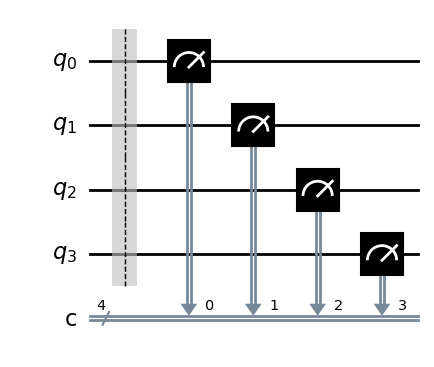

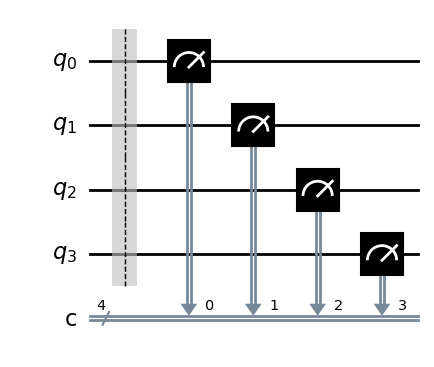

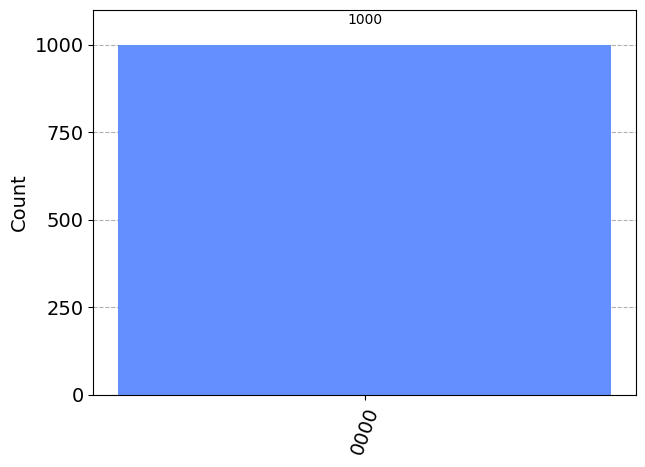

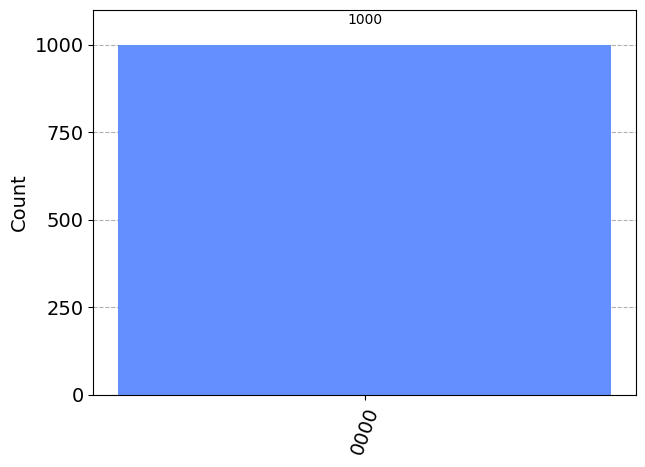

In [104]:
#---CIRCUITO CUANTICO DE PRUEBA---
qc = QuantumCircuit(4,4)

qc.barrier()
qc.measure(range(4),range(4))

display(qc.draw('mpl'))

simulator1 = AerSimulator(noise_model=noise_model)
simulator2 = AerSimulator()

qc_transpiled = transpile(qc,basis_gates=conf.basis_gates)
display(qc_transpiled.draw('mpl'))

simulation_result1 = simulator2.run(qc_transpiled,shots=1000).result()
simulation_result2 = simulator2.run(qc_transpiled,shots=1000).result()


display(plot_histogram(simulation_result1.get_counts(0)))
display(plot_histogram(simulation_result2.get_counts(0)))